Would you like to compare simulate data or realworld data training with sklearn?
Please enter 'simulate' or 'realworld'realworld
Start sklearn training process..
Coordinate descent iteration 100
Coordinate descent iteration 200
Coordinate descent iteration 300
Coordinate descent iteration 400
Coordinate descent iteration 500
Coordinate descent iteration 600
Coordinate descent iteration 700
Coordinate descent iteration 800
Coordinate descent iteration 900
Coordinate descent iteration 1000
Coordinate descent iteration 100
Coordinate descent iteration 200
Coordinate descent iteration 300
Coordinate descent iteration 400
Coordinate descent iteration 500
Coordinate descent iteration 600
Coordinate descent iteration 700
Coordinate descent iteration 800
Coordinate descent iteration 900
Coordinate descent iteration 1000


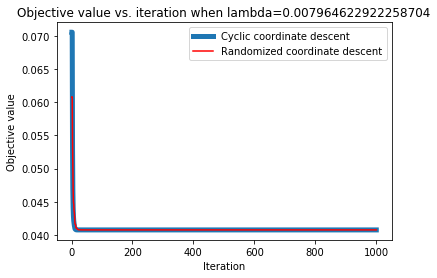

Coefficients trained from sklearn: [-0.          0.         -0.01915263  0.02611769 -0.          0.04858859
  0.         -0.05225029  0.         -0.06585153 -0.05554188  0.03891684
 -0.25377746]
Coefficients trained from cyclic coordinate descent algorithm: [ 0.          0.         -0.01912082  0.02611384  0.          0.04858103
  0.         -0.05224574  0.         -0.06585766 -0.05554642  0.03891675
 -0.25379462]
Coefficients trained from randomized coordinate descent algorithm: [ 0.          0.         -0.01912082  0.02611384  0.          0.04858103
  0.         -0.05224574  0.         -0.06585766 -0.05554642  0.03891675
 -0.25379462]


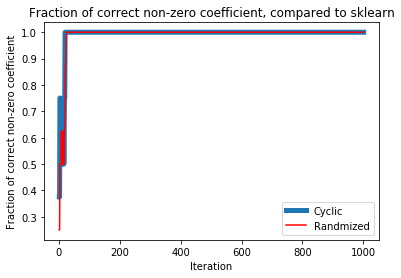

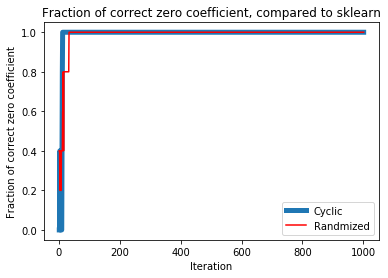

Training process finished. Thank you for viewing!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import copy

class Sklearn:
	"""
	This is a demo of using scikit-learn to solve the LASSO problem, that is the `l1-regularized 
	least-squares regression problem. 
	"""
	def __init__(self):
		"""
		Using scikit-learn to solve the LASSO problem.
		Parameters
		----------
		data : str
		A real world data set is being used:
		'https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'
		
		"""
		self.data = '/users/Sushanta/Documents/GitHub/Illinois/CS598 Practical Statistical Learning/Coding2_myData.csv'
		
	def generate_simulate_data(self):
		"""
		Generate simulated data sets and standarize data.
		"""
		n = 100
		np.random.seed(0)
		X = np.random.normal(loc=1, scale=1, size=n)
		epsilon = np.random.normal(loc=0, scale=0.01, size=n)
		beta0 = 1
		beta1 = 2
		beta2 = 3
		beta3 = 4
		y = beta0 + beta1*X + beta2*X**2 + beta3*X**3 + epsilon
		predictors = np.vstack([X**i for i in range(1, 11)]).T
		scaler = preprocessing.StandardScaler()
		predictors = scaler.fit_transform(predictors)
		y = y-np.mean(y)
		x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.25, random_state=0)
		return x_train, x_test, y_train, y_test

	def process_data(self):
		"""
		Read and standarize data.
		"""
		data = pd.read_csv(self.data, sep=',', header=0)   
		#hitters = hitters.dropna() 
		X = data.drop('Y', axis=1) 
		X = pd.get_dummies(X, drop_first=True) 
		y = data.Y
		x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0) #By default, 25% goes into the test set.
		std_scale = preprocessing.StandardScaler().fit(x_train)
		x_train = std_scale.transform(x_train)
		x_test = std_scale.transform(x_test)
		y_train=preprocessing.scale(y_train, with_mean=True, with_std=False)
		return x_train, x_test, y_train, y_test

	def sklearn_training(self, x, y):
		"""
		Using scikit-learn Lasso cross validation to train data
		return optimal lambda and coefficients
		"""
		lasso_model = linear_model.LassoCV(cv=10, n_alphas=1000, fit_intercept=False, max_iter=1000)
		lasso_fit = lasso_model.fit(x, y)
		optimal_alpha = lasso_fit.alpha_
		beta_star = lasso_fit.coef_
		return optimal_alpha, beta_star

class Algorithm:
	"""
	This is a demo of using coordinate descent algorithm (including both cyclic coordinate descent 
	and randomized coordinate descent) to solve the LASSO problem, that is the `l1-regularized 
	least-squares regression problem. The results are being compared with scikit-learn results.
	"""
	def __init__(self, lambduh, beta_star):
		"""
		Coordinate descent algorithm to solve the LASSO problem.
		Parameters
		----------
		lambduh : float
		Regularization parameter.
		The default lambduh is set as 6.46, the same as optimal lambduh from sklearn, in order to compare 
		with sklearn performance. 
		
		data : str
		A real world data set is being used:
		'https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'
		max_iter: int
		Default is set as 1000, the same as sklearn, in order to compare 
		with sklearn performance. 
		
		"""
		self.lambduh = lambduh
		self.beta_star = beta_star
		self.max_iter = 1000


	def soft_threshold(self, a, lambduh):
		"""
		Solving l1-norm gradient problem
		"""
		if a < -lambduh:
			return a+lambduh
		elif a > lambduh:
			return a-lambduh
		else:
			return 0
				   

	def min_beta_multivariate(self, x, y, beta, j):
		"""
		Solving partial minimization problem with respect to beta_j for any j = 1...d.
		"""
		n = len(y)
		selector = [i for i in range(x.shape[1]) if i != j]
		norm_x_j = np.linalg.norm(x[:, j])
		a = x[:, j].dot(y[:, np.newaxis] - x[:, selector].dot(beta[:, np.newaxis][selector, :]))
		passin = self.lambduh*n/2
		res = self.soft_threshold(a, passin)
		return res/(norm_x_j**2)

	def computeobj(self, beta, x, y):
		"""
		Compute objective value with certain beta.
		"""
		n = len(y)
		return 1/n*np.sum((y-x.dot(beta))**2) + self.lambduh*np.linalg.norm(beta, ord=1)

	def cycliccoorddescent(self, x, y, beta_init):
		"""
		cycliccoorddescent that implements the cyclic coordinate descent algorithm. The cyclic 
		coordinate descent algorithm proceeds sequentially. At each iteration, the algorithm 
		increments the index j of the coordinate to minimize over. Then the algorithm performs 
		partial minimization with respect to the coordinate beta_j corresponding to that index. 
		After updating the coordinate beta_j , the algorithm proceeds to the next iteration. 
		The function takes as input the initial point, the initial step-size value, and the 
		maximum number of iterations. The stopping criterion is the maximum number of iterations.
		"""
		beta = copy.deepcopy(beta_init)
		beta_vals = beta
		d = np.size(x, 1)
		iter = 0
		while iter < self.max_iter:        
			for j in range(d):
				min_beta_j = self.min_beta_multivariate(x, y, beta, j)
				beta[j] = min_beta_j
			beta_vals = np.vstack((beta_vals, beta))
			iter += 1
			if iter % 100 == 0:
				print('Coordinate descent iteration', iter)
		return beta_vals

	def pickcoord(self, d, j):
		"""
		samples uniformly from the set  j = 1...d..
		"""
		num = np.random.randint(0, d)
		while num == j:
			num = np.random.randint(0, d) 
		return num

	def randcoorddescent(self, x, y, beta_init):
		"""
		Randcoorddescent that implements the randomized coordinate descent algorithm. The 
		randomized coordinate descent algorithm proceeds as follows. At each iteration, 
		the algorithm samples the index j of the coordinate to minimize over. Then the 
		algorithm performs partial minimization with respect to the coordinate beta_j 
		corresponding to that index. After updating the coordinate beta_j , the algorithm 
		proceeds to the next iteration. The function takes as input the initial point, 
		the initial step-size value, and the maximum number of iterations. The stopping 
		criterion is the maximum number of iterations.
		"""
		beta = copy.deepcopy(beta_init)
		beta_vals = beta
		d = np.size(x, 1)
		iter = 0
		while iter < self.max_iter:
			j = -1
			for i in range(d):
				j=self.pickcoord(d, j)
				min_beta_j = self.min_beta_multivariate(x, y, beta, j)
				beta[j] = min_beta_j
			beta_vals = np.vstack((beta_vals, beta))
			iter += 1
			if iter % 100 == 0:
				print('Coordinate descent iteration', iter)
		return beta_vals

	def objective_plot(self, betas_cyclic, betas_rand, x, y):
		"""
		Plot the curves of the objective values F(beta_t) for both algorithms versus 
		the iteration counter iter (use different colors)
		"""
		num_points = np.size(betas_cyclic, 0)
		objs_cyclic = np.zeros(num_points)
		objs_rand = np.zeros(num_points)
		for i in range(0, num_points):
			objs_cyclic[i] = self.computeobj(betas_cyclic[i, :], x, y)
			objs_rand[i] = self.computeobj(betas_rand[i, :], x, y)
		fig, ax = plt.subplots()
		ax.plot(range(1, num_points + 1), objs_cyclic, label='Cyclic coordinate descent', linewidth=5.0) 
		ax.plot(range(1, num_points + 1), objs_rand, c='red', label='Randomized coordinate descent')
		plt.xlabel('Iteration')
		plt.ylabel('Objective value')
		plt.title('Objective value vs. iteration when lambda='+str(self.lambduh))
		ax.legend(loc='upper right')
		plt.show()

	def fraction_of_correct_non_zero_coefficients(self, beta_opts):
		"""
		Calculate fraction of non zero coefficients of coordinate descent algorithm compared to sklearn
		"""
		denom = 0
		nom = 0
		for i in range(len(self.beta_star)):
			if self.beta_star[i] != 0:
				denom +=1
				if (self.beta_star[i] - beta_opts[i])/self.beta_star[i] < 0.01:
					nom += 1
		return nom/denom   

	def fraction_of_correct_zero_coefficients(self, beta_opts):
		"""
		Calculate fraction of zero coefficients of coordinate descent algorithm compared to sklearn
		"""
		denom = 0
		nom = 0
		for i in range(len(self.beta_star)):
			if self.beta_star[i] == 0:
				denom +=1
				if beta_opts[i] == 0:
					nom += 1
		return nom/denom

	def plot_correct_coefficient(self, betas_cyclic, betas_rand, f, title, ylabel):
		"""
		Plot the curves of fraction of non-zero and zero coefficients of coordinate descent algorithm
		compared to sklearn versus the iteration counter iter
		"""
		niter = np.size(betas_cyclic, 0)
		fraction_cyclic = np.zeros(niter)
		fraction_rand = np.zeros(niter)
		for i in range(niter):
			fraction_cyclic[i] = f(betas_cyclic[i, :])
			fraction_rand[i] = f(betas_rand[i, :])
		fig, ax = plt.subplots()
		
		ax.plot(range(1, niter + 1), fraction_cyclic, label='Cyclic', linewidth=5.0)
		ax.plot(range(1, niter + 1), fraction_rand, c='red', label='Randmized')
		plt.xlabel('Iteration')
		plt.ylabel(ylabel)
		if title:
			plt.title(title)
		ax.legend(loc='lower right')
		plt.show()


if __name__=='__main__':
	"""
	Start training process and compare with sklearn results once the file is directly called.
	"""
	print('Would you like to compare simulate data or realworld data training with sklearn?')
	datatype = input("Please enter 'simulate' or 'realworld'")
	print('Start sklearn training process..')
	sklearn = Sklearn()
	if datatype ==  'realworld':
		x_train, x_test, y_train, y_test = sklearn.process_data()
	elif datatype == 'simulate':
		x_train, x_test, y_train, y_test = sklearn.generate_simulate_data()
	optimal_alpha, betas_star = sklearn.sklearn_training(x_train, y_train)
	algorithm = Algorithm(lambduh=optimal_alpha*2, beta_star=betas_star)
	beta_init = np.zeros(np.size(x_train, 1))
	betas_cyclic = algorithm.cycliccoorddescent(x_train, y_train, beta_init)
	betas_rand = algorithm.randcoorddescent(x_train, y_train, beta_init)
	algorithm.objective_plot(betas_cyclic, betas_rand, x_train, y_train)
	print('Coefficients trained from sklearn:', betas_star)
	print('Coefficients trained from cyclic coordinate descent algorithm:', betas_cyclic[-1, :])
	print('Coefficients trained from randomized coordinate descent algorithm:', betas_rand[-1, :])
	algorithm.plot_correct_coefficient(betas_cyclic, betas_rand, 
						 algorithm.fraction_of_correct_non_zero_coefficients, 
						 'Fraction of correct non-zero coefficient, compared to sklearn', 
						 'Fraction of correct non-zero coefficient')
	algorithm.plot_correct_coefficient(betas_cyclic, betas_rand, 
						 algorithm.fraction_of_correct_zero_coefficients, 
						 'Fraction of correct zero coefficient, compared to sklearn', 
						 'Fraction of correct zero coefficient')

	print('Training process finished. Thank you for viewing!')